In [ ]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn.modules.activation import LeakyReLU

import os
import sys
import matplotlib.pyplot as plt

In [ ]:
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

import math
import json

In [ ]:
data_path = '/content/drive/MyDrive/HSE/DL/Project/data/genres_original'
json_path = '/content/drive/MyDrive/HSE/DL/Project/data/mfcc_splited/data.json'

In [ ]:
SAMPLE_RATE = sr =  22050
DURATION = 30 #measured in seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION    # 661794
n_mfcc=13

Функция для разделения аудиозаписей на 10 частей, извлечения последовательности MFCC и сохранение их в виде .json файла

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    data = {
        'names' : [],
        'mfcc' : [],
        'labels' : []
    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)    # делим все песни на num_segments=10
    expected_num_mfcc_vectors_per_segment = np.ceil(num_samples_per_segment / hop_length)    # 65
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath not in dataset_path:
            print(dirpath.split('/')[-1])
            #process files for a specific genre 
            for f in tqdm(filenames):
                if f.endswith('.wav') and f != 'jazz.00054.wav': # jazz.00054.wav is an empty file
                    file_path = os.path.join(dirpath,f)
                    #loading the audio file 
                    signal, sr = sf.read(file_path) # len(signal) = 661794  # sr is 22050 by default 
                    for s in range(num_segments): 
                        start_sample = num_samples_per_segment * s   
                        finish_sample = start_sample + num_samples_per_segment
                        mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i-1)
                            data['names'].append(f'{f[:-4]}.{s}.wav')

    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [ ]:
# save_mfcc(data_path, json_path, n_mfcc=n_mfcc, num_segments=10)

In [ ]:
with open(json_path, 'r') as f:
    data = json.load(f)
    
#Convert lists into numpy arrays
filenames = np.array(data['names'])
inputs = np.array(data['mfcc']).astype('float64')
targets = np.array(data['labels']) 


In [ ]:
inputs.shape

(9989, 65, 13)

In [ ]:
genres = [filenames[900+1000*i].split('.')[0] for i in range(10)]
genres

['rock',
 'country',
 'jazz',
 'blues',
 'pop',
 'reggae',
 'disco',
 'hiphop',
 'metal',
 'classical']

In [ ]:
seed=42

Теперь будем обучать модель. Введем все необходимые функции

In [ ]:
def my_train_test_split(X, y, filenames, test_size=0.2, seed=42):
    assert X.shape[0] == y.shape[0] == filenames.shape[0]
    np.random.seed = seed
    idx = np.random.permutation(X.shape[0])
    n = int(test_size * X.shape[0])

    X, y, filenames = X[idx], y[idx], filenames[idx]
    X_train, X_test = X[n:], X[:n]
    y_train, y_test = y[n:], y[:n]
    filenames_train, filenames_test = filenames[n:], filenames[:n]
    return X_train, X_test, y_train, y_test, filenames_train, filenames_test

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0]
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(inputs, targets, filenames, test_size=0.2, seed=seed)

X_val, X_test, y_val, y_test, filenames_train, filenames_test\
        = my_train_test_split(X_test, y_test, filenames_test, test_size=0.5, seed=seed)

# Adding Noise 
X_train += np.random.rand(*X_train.shape).astype('float64')

In [ ]:
def count_acc(y_true, y_pred):
    # print(y_true.shape)
    # print(y_pred.shape)
    return (torch.argmax(y_pred, dim=-1) == y_true).sum().float().item() / y_true.shape[0]

Фукция для обучения модели

In [ ]:
def train_model(model, loss, optim, epochs, device, dataloaders):
    dataloader_train, dataloader_val, dataloader_test = dataloaders
    train_loss_all, val_loss_all, train_acc_all, val_acc_all = [], [], [], []
    # training loop
    for epoch in range(epochs):
        # train
        train_loss, train_acc = single_pass(model, dataloader_train, loss, device, optim)
        # validation
        with torch.no_grad():
            val_loss, val_acc = single_pass(model, dataloader_val, loss, device)

        print(
            f'epoch {epoch}, train_loss={train_loss}, validation_loss={val_loss}, train_acc={train_acc}, val_acc={val_acc}')

        train_loss_all.append(train_loss)
        val_loss_all.append(val_loss)
        train_acc_all.append(train_acc)
        val_acc_all.append(val_acc)

    # test
    model.eval()
    with torch.no_grad():
        test_loss, test_acc = single_pass(model, dataloader_test, loss, device)
        # test_AUC = count_auc(model, device, dataloader_test)
        # pres, rec, f1 = count_pres_rec_f1(model, device, dataloader_test)

        # print(f'test_loss={test_loss}, test_acc={test_acc}')
        # print('test_AUC=', test_AUC)
        # print('pres=', pres, 'rec=', rec, 'f1=', f1)
    model.train()

    return train_loss_all, val_loss_all, train_acc_all, val_acc_all, test_loss, test_acc

In [ ]:
def plot_results(ax, train_results: list, val_results: list, test_result, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    ax.plot(epochs[-1], test_result,
            marker='o', linestyle='none', label='test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()

In [ ]:
def single_pass(model, dataloader, loss_func, device, optim=None):
    loss_count, acc_count = 0, 0
    for i, (X, y_true) in enumerate(dataloader):
        X, y_true = X.to(device), y_true.to(device)
        # print(X.shape, print(X))
        pred = model.forward(X)
        loss = loss_func(pred, y_true)
        loss_count += loss.item()
        acc_count += count_acc(y_true, pred)
        # roc_auc += roc_auc_score(labels, pred, average='macro')
        if optim is not None:
            loss.backward()
            optim.step()
    return loss_count / len(dataloader), acc_count / len(dataloader)

# Model

In [ ]:
from torch.nn.modules.activation import LeakyReLU

class my_rnn(nn.Module):
    def __init__(self):
        super().__init__()
        # self.lstm1 = nn.LSTM(input_size=n_mfcc, hidden_size=100, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=100, hidden_size=500, batch_first=True)

        self.gru1 = nn.GRU(input_size=n_mfcc, hidden_size=100, batch_first=True)
        self.gru2 = nn.GRU(input_size=100, hidden_size=500, batch_first=True)
        # self.gru3 = nn.GRU(input_size=500, hidden_size=1000, batch_first=True)

        self.drop = nn.Dropout(p=0.2)
        self.bn = nn.BatchNorm1d(500)    # (N, 100, L)

        self.classificator = nn.Sequential( 
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        # output, (h_n, c_n) = self.lstm1(x)   # (N,100,L), (1, N, 100)      # (output, (h_n, c_n))
        # output, (h_n, c_n) = self.lstm2(output)
        output, h_n = self.gru1(x)
        output, h_n = self.gru2(output)
        # output, h_n = self.gru3(output)

        x = nn.LeakyReLU()(h_n[0])    # (N, 100)
        x = self.drop(x)
        x = self.bn(x)
        x = self.classificator(x)
        # print(x.shape)
        return x
        


Параметры обучения

In [ ]:
model = my_rnn().double()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 128
epochs = 50
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)
loss = F.cross_entropy

In [ ]:
sum(p.numel() for p in model.parameters())

989610

In [ ]:
dataloader_train = DataLoader(MyDataset(X_train, y_train), batch_size=batch_size)
dataloader_val = DataLoader(MyDataset(X_val, y_val), batch_size=batch_size)
dataloader_test = DataLoader(MyDataset(X_test, y_test), batch_size=batch_size)

dataloaders = [dataloader_train, dataloader_val, dataloader_test]

In [ ]:
def my_subplots(train_loss, val_loss, train_acc, val_acc, test_loss, test_acc):
    _, ax1 = plt.subplots()
    plot_results(ax1, train_loss, val_loss, test_loss, 'Loss')
    _, ax2 = plt.subplots()
    plot_results(ax2, train_acc, val_acc, test_acc, 'Accuracy')
    plt.show()

epoch 0, train_loss=0.8154139618148699, validation_loss=1.1094791828579689, train_acc=0.706172052154195, val_acc=0.634253640776699
epoch 1, train_loss=0.7799747479769792, validation_loss=1.1609343939128813, train_acc=0.714781746031746, val_acc=0.6281856796116505
epoch 2, train_loss=0.803963317581675, validation_loss=1.1292191390735233, train_acc=0.7135062358276644, val_acc=0.661597390776699
epoch 3, train_loss=0.7701413126097375, validation_loss=1.152679506119014, train_acc=0.7260487528344671, val_acc=0.6578712833737864
epoch 4, train_loss=0.7897391701121296, validation_loss=1.1818865061225678, train_acc=0.721655328798186, val_acc=0.654467536407767
epoch 5, train_loss=0.7283811429787462, validation_loss=1.1597966660408485, train_acc=0.7440299036281179, val_acc=0.6505897299757282
epoch 6, train_loss=0.7477792792566478, validation_loss=1.157315528761143, train_acc=0.742453231292517, val_acc=0.6286597390776699
epoch 7, train_loss=0.7559818763569053, validation_loss=1.1539482435088202, tra

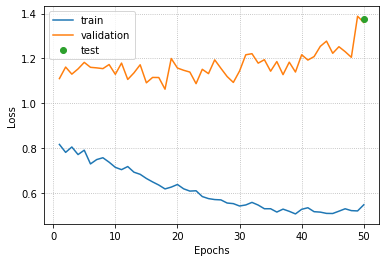

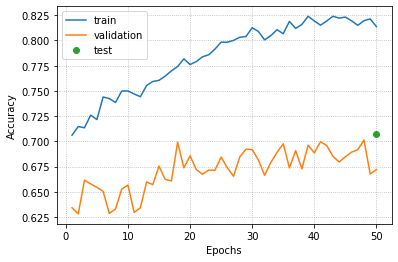

In [ ]:
my_subplots(*train_model(model, loss, optim, epochs, device, dataloaders))

Не посчитал метрики, а так получился неплохой результат

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def count_metrics(y_true, y_pred, genres, average='macro', plot=True):
    # average metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred,  average=average)
    print(f'Average: acc: {acc:.3f} prec: {prec:.3f} rec: {rec:.3f}')

    # mertics per class
    multi_recall = recall_score(y_true, y_pred, average=None)
    multi_precision = precision_score(y_true, y_pred, average=None)
    print('Per class precision, recall')
    for i, (pre, re) in enumerate(zip(multi_precision, multi_recall)):
        print(f'{genres[i]:>10}:  {pre:.3f}  {re:.3f}')

In [ ]:
model.eval()
y_pred = torch.argmax(model.forward(torch.Tensor(X_test).double().to(device)), dim=-1).detach().cpu().numpy()

In [ ]:
y_pred

array([7, 4, 2, 1, 4, 9, 7, 8, 9, 7, 8, 2, 4, 4, 7, 8, 4, 8, 5, 3, 4, 0,
       7, 5, 7, 7, 1, 4, 8, 2, 2, 7, 7, 2, 6, 8, 3, 8, 1, 4, 0, 3, 9, 4,
       3, 6, 3, 1, 3, 3, 8, 1, 8, 1, 3, 2, 7, 8, 1, 8, 5, 1, 8, 3, 6, 7,
       4, 8, 2, 9, 2, 7, 6, 1, 5, 5, 3, 3, 8, 2, 7, 5, 3, 6, 1, 3, 5, 8,
       4, 4, 9, 6, 2, 1, 9, 9, 3, 2, 7, 9, 1, 9, 3, 9, 3, 4, 7, 3, 4, 3,
       9, 3, 9, 6, 8, 8, 6, 1, 6, 5, 7, 2, 5, 8, 7, 4, 3, 9, 1, 1, 7, 7,
       5, 1, 3, 0, 7, 8, 6, 8, 1, 8, 7, 5, 2, 5, 4, 2, 3, 4, 9, 9, 7, 4,
       4, 3, 4, 7, 6, 6, 9, 5, 3, 7, 4, 4, 9, 3, 4, 4, 2, 3, 2, 7, 6, 1,
       3, 8, 7, 5, 4, 1, 8, 6, 1, 1, 8, 9, 3, 3, 3, 9, 3, 3, 2, 8, 2, 2,
       6, 5, 1, 8, 9, 2, 4, 4, 6, 9, 7, 1, 4, 4, 7, 8, 2, 7, 3, 2, 4, 4,
       6, 1, 8, 3, 6, 7, 1, 7, 4, 1, 1, 3, 9, 7, 8, 6, 6, 7, 7, 6, 3, 4,
       3, 3, 6, 9, 4, 7, 8, 9, 9, 8, 2, 8, 2, 4, 3, 4, 3, 2, 4, 3, 6, 8,
       2, 8, 9, 5, 2, 5, 7, 8, 5, 8, 7, 2, 7, 1, 3, 3, 9, 1, 9, 8, 7, 8,
       0, 3, 7, 6, 9, 6, 9, 8, 8, 3, 6, 3, 3, 6, 6,

In [ ]:
y_test

array([7, 6, 2, 1, 4, 9, 7, 1, 9, 3, 8, 2, 4, 6, 4, 8, 0, 8, 5, 3, 6, 9,
       7, 7, 7, 7, 2, 2, 3, 2, 2, 0, 6, 8, 8, 8, 1, 0, 1, 4, 4, 3, 9, 4,
       3, 6, 3, 1, 3, 6, 8, 1, 8, 1, 3, 0, 7, 8, 1, 8, 5, 0, 8, 3, 6, 7,
       4, 8, 5, 2, 5, 3, 6, 4, 5, 5, 3, 5, 2, 2, 6, 5, 1, 6, 4, 3, 5, 8,
       4, 7, 9, 6, 2, 1, 2, 2, 3, 0, 7, 9, 2, 2, 3, 9, 1, 4, 4, 3, 1, 0,
       9, 0, 9, 1, 8, 8, 6, 0, 6, 5, 7, 5, 5, 8, 7, 7, 3, 9, 1, 0, 6, 7,
       5, 1, 0, 6, 7, 0, 6, 8, 2, 8, 7, 5, 9, 5, 4, 3, 3, 0, 2, 9, 7, 4,
       6, 0, 0, 7, 6, 5, 9, 7, 3, 3, 6, 4, 9, 1, 7, 4, 2, 3, 2, 7, 5, 6,
       1, 3, 3, 5, 6, 1, 8, 6, 0, 1, 0, 9, 3, 3, 3, 1, 3, 3, 2, 1, 2, 2,
       1, 5, 1, 8, 2, 2, 4, 6, 3, 9, 7, 2, 5, 4, 7, 8, 2, 5, 1, 2, 4, 4,
       6, 1, 3, 1, 2, 7, 1, 7, 4, 2, 1, 3, 9, 5, 7, 6, 0, 7, 6, 6, 3, 5,
       3, 3, 9, 9, 4, 7, 8, 9, 9, 8, 2, 8, 1, 4, 3, 4, 1, 2, 4, 7, 7, 8,
       2, 3, 9, 5, 2, 5, 6, 8, 5, 3, 7, 2, 5, 1, 3, 3, 9, 1, 2, 8, 7, 8,
       0, 3, 7, 0, 2, 5, 9, 8, 8, 2, 5, 3, 6, 0, 6,

In [ ]:
count_metrics(y_test, y_pred, genres)